First, dive in and explore the data set. Include your code and visuals from this process in your final write up. While doing this, look for something that provokes a question; specifically one that can be answered with an experiment.

The main component of this capstone is a research proposal. Using the data set you selected, propose and outline an experiment plan. The plan should consist of three key components:
   - Analysis that highlights your experimental hypothesis.
   - A rollout plan showing how you would implement and rollout the experiment
   - An evaluation plan showing what constitutes success in this experiment

In [1]:
# AG to do's: test date axis subsets, QQ plot

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from datetime import date
from datetime import datetime

In [3]:
calendar = pd.read_csv('calendar (sf).csv')
listings = pd.read_csv('listings (sf).csv')
reviews  = pd.read_csv('reviews (sf).csv')

<b>Notes for Brad</b>
My idea is for AirBnB to run an experiment where certain listings are given an "AirBnb Recommends" tag. Similar to Amazon recommended products, this tag would likely drive higher utilization of recommended properties, and could be used to reward properties that have positive effects for Airbnb (e.g., lead to a higher usage of Airbnb Experiences in the city).

Before launching such a feature, AirBnb should test the hypothesis that an "AirBnb Recommends" tag would drive higher utilization of tagged properties.

To prepare for the experiement, we should review the Airbnb data we have available to consider how the experiment should be implemented. Specifically, I recommend we:
- come up with a measure of calendar availablility based on the calendar table
- come up with an indicator of positive/negative sentiment based on the review table
- determine which columns in the listings table are ammenable to quantitative measures that we can use to segment different types of listings

<b>Additional hypothesis:</b> Airbnb could use this to nudge customers towards higher price (therefore higher revenue generating) listings, specifically underutilized high-price listings

In [4]:
###STEP 1: Explore the Listings Table

In [5]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20181003014841,2018-10-03,"Bright, Modern Garden Unit - 1BR/1B",Our bright garden unit overlooks a grassy back...,"Newly remodeled, modern, and bright garden uni...",Our bright garden unit overlooks a grassy back...,none,*Quiet cul de sac in friendly neighborhood *St...,...,t,STR-0001256,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1.43
1,5858,https://www.airbnb.com/rooms/5858,20181003014841,2018-10-03,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,t,NaN,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,1,0.98
2,7918,https://www.airbnb.com/rooms/7918,20181003014841,2018-10-03,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,t,NaN,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,9,0.15
3,8142,https://www.airbnb.com/rooms/8142,20181003014841,2018-10-03,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,Nice and good public transportation. 7 minute...,none,NaN,...,t,NaN,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,9,0.16
4,8339,https://www.airbnb.com/rooms/8339,20181003014841,2018-10-03,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,none,NaN,...,t,STR-0000264,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,t,t,2,0.25


In [6]:
#checking out the values for 'host response time' in the listings table
listings['host_response_time'].unique()

array(['within an hour', nan, 'within a few hours', 'within a day',
       'a few days or more'], dtype=object)

In [7]:
#checking out the type of 'host since' in the listings table
type(listings['host_since'][1])

str

In [8]:
#checking whether hosts have multiple 'host_since' dates (for each listing) 
listings[['host_id','host_since']].groupby('host_id').aggregate('count').head()

,host_since
host_id,
46,1
470,1
1169,1
4921,2
6267,1


In [9]:
#creating my analysis df
listing_analysis = pd.DataFrame()
listing_analysis['listing_id'] = listings['id']
listing_analysis['listed_since'] = listings['host_since']
listing_analysis['review_count'] = listings['number_of_reviews']
listing_analysis['review_count'] = listings['number_of_reviews']
listing_analysis['review_score'] = listings['review_scores_rating']
listing_analysis['monthly_reviews'] = listings['reviews_per_month']

#get prices, converting to floats
listing_analysis['price ($)'] = listings['price'].apply(lambda x: float(''.join(list(filter(str.isdigit, str(x))))))/100

#create dummy variables for response time values 
listing_analysis['responds within an hour'] = 0
for i in listing_analysis.index:
    if listings.at[i,'host_response_time'] == 'within an hour':
        listing_analysis.at[i,'responds within an hour'] = 1
    else:
        listing_analysis.at[i,'responds within an hour'] = 0
listing_analysis['responds within a few hours'] = 0
for i in listing_analysis.index:
    if listings.at[i,'host_response_time'] == 'within a few hours':
        listing_analysis.at[i,'responds within a few hours'] = 1
    else:
        listing_analysis.at[i,'responds within a few hours'] = 0
listing_analysis['responds within a day'] = 0
for i in listing_analysis.index:
    if listings.at[i,'host_response_time'] == 'within a day':
        listing_analysis.at[i,'responds within a day'] = 1
    else:
        listing_analysis.at[i,'responds within a day'] = 0
listing_analysis['responds slowly or no data'] = 0
for i in listing_analysis.index:
    if max(listing_analysis.at[i,'responds within an hour'],listing_analysis.at[i,'responds within a few hours'],listing_analysis.at[i,'responds within a day']) == 0:
        listing_analysis.at[i,'responds slowly or no data'] = 1
    else:
        listing_analysis.at[i,'responds slowly or no data'] = 0

        
        
listing_analysis.head()


,listing_id,listed_since,review_count,review_score,monthly_reviews,price ($),responds within an hour,responds within a few hours,responds within a day,responds slowly or no data
0,958,2008-07-31,160,97.0,1.43,170.0,1,0,0,0
1,5858,2009-03-02,112,98.0,0.98,235.0,0,0,0,1
2,7918,2009-06-17,17,85.0,0.15,65.0,0,1,0,0
3,8142,2009-06-17,8,93.0,0.16,65.0,0,1,0,0
4,8339,2009-07-02,27,97.0,0.25,785.0,0,0,0,1


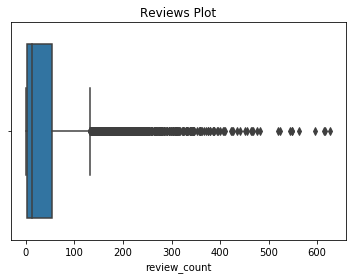

In [10]:
#look at scores plot
sns.boxplot(listing_analysis['review_count']) 
plt.title('Reviews Plot')
plt.show()

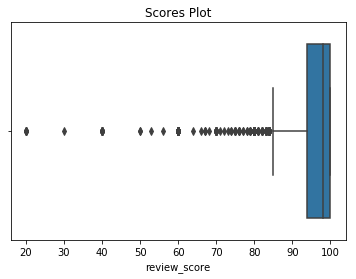

In [11]:
#look at scores plot
sns.boxplot(listing_analysis['review_score']) 
plt.title('Scores Plot')
plt.show()

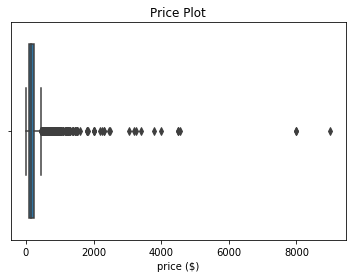

In [12]:
#look at price plot
sns.boxplot(listing_analysis['price ($)']) 
plt.title('Price Plot')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


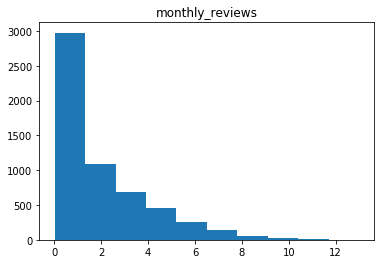

In [13]:
#look at price plot
plt.hist(listing_analysis['monthly_reviews'])
plt.title('monthly_reviews')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


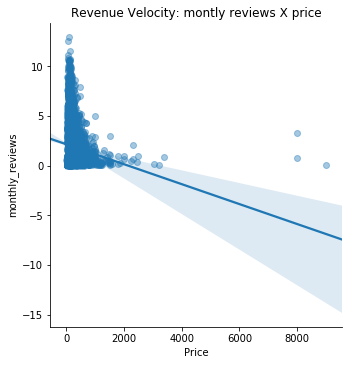

In [14]:
#check correlation between reviews and score
g = sns.lmplot(y='monthly_reviews', x='price ($)', data=listing_analysis, 
               fit_reg=True, scatter_kws={'alpha':0.4})
g.set_ylabels("monthly_reviews")
g.set_xlabels("Price")
plt.title('Revenue Velocity: montly reviews X price')
plt.show()

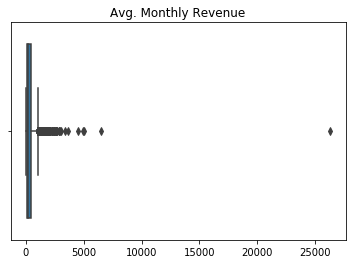

In [15]:
#look at price plot
sns.boxplot(listing_analysis['monthly_reviews']*listing_analysis['price ($)'])
plt.title('Avg. Monthly Revenue')
plt.show()

<b>Initial summary:</b> For now, if we assume that review velocity and price is steady over time, we can do some interesting anlaysis on the relationship between price/score/popularity/velocity if we exclude outliers, or <u>focus</u> on the outliers that generate outsize profit (i.e., high price stays at a high velocity)

Before doing further analysis on the listings table, I will explore the calendar and reviews tables

In [16]:
reviews.head()

,listing_id,id,review_date,reviewer_id,reviewer_name,comments
0,958,5977,7/23/09,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,8/3/09,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,9/27/09,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,11/5/09,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2/13/10,15416,Venetia,Holly's place was great. It was exactly what I...


The reviews table gives us the ability to replace the reviews per month metric from the listings table with a more relevant metric, e.g., reviews in the past year. However, because it is scraped public data, it does not include the detailed scores. I propose to rerun the analysis we do on the listings table on a subset of recent data, to make sure it holds up in the most relevant timeframe.

In [17]:
calendar.head()

,listing_id,calendar_date,available,price
0,8739,10/2/19,f,NaN
1,958,10/2/19,f,NaN
2,8739,10/1/19,f,NaN
3,8739,9/30/19,f,NaN
4,8739,9/29/19,f,NaN


In [18]:
availability = calendar.copy()
availability['year_month'] = 0
for i in availability.index:
    availability.at[i,'date'] = datetime.strptime(availability.at[i,'calendar_date'], '%m/%d/%y').replace(day=1)
#FYI, this runs super slow...

In [19]:
availability.head()

,listing_id,calendar_date,available,price,year_month,date
0,8739,10/2/19,f,NaN,0,2019-10-01
1,958,10/2/19,f,NaN,0,2019-10-01
2,8739,10/1/19,f,NaN,0,2019-10-01
3,8739,9/30/19,f,NaN,0,2019-09-01
4,8739,9/29/19,f,NaN,0,2019-09-01


In [32]:
availability[['listing_id','date','calendar_date']].groupby(['listing_id', 'date']).count()

calendar_date
listing_id date                     
958        2018-10-01             29
           2018-11-01             30
           2018-12-01             31
           2019-01-01             31
           2019-02-01             28
           2019-03-01             31
           2019-04-01             30
           2019-05-01             31
           2019-06-01             30
           2019-07-01             31
           2019-08-01             31
           2019-09-01             30
           2019-10-01              2
5858       2018-10-01             29
           2018-11-01             30
           2018-12-01             31
           2019-01-01             31
           2019-02-01             28
           2019-03-01             31
           2019-04-01             30
           2019-05-01             31
           2019-06-01             30
           2019-07-01             31
           2019-08-01             31
           2019-09-01             30
           2019-10-01              2
7918       2018-10-01             29
           2018-11-01             30
           2018-12-01             31
           2019-01-01             31
...                              ...
13219968   2019-07-01             31
           2019-08-01             31
           2019-09-01             30
           2019-10-01              2
13220623   2018-10-01             29
           2018-11-01             30
           2018-12-01             31
           2019-01-01             31
           2019-02-01             28
           2019-03-01             31
           2019-04-01             30
           2019-05-01             31
           2019-06-01             30
           2019-07-01             31
           2019-08-01             31
           2019-09-01             30
           2019-10-01              2
13223141   2018-10-01              6
           2018-11-01             30
           2018-12-01             31
           2019-01-01             31
           2019-02-01             28
           2019-03-01             31
           2019-04-01             30
           2019-05-01             31
           2019-06-01             30
           2019-07-01             31
           2019-08-01              8
           2019-09-01             30
           2019-10-01              2

[37350 rows x 1 columns]